<center><h1>Modeling & Prediction</h1></center>  
<center><h6>AI-Powered Price Optimization</h6></center>  

This notebook represents the third stage of our **Airbnb Smart Pricing project** ETL pipeline. Having prepared and cleaned our dataset, we now focus on building a machine learning model that predicts the optimal nightly price for Airbnb listings. The goal is to develop a model that provides pricing recommendations with real business value. These predictions will feed into the final dashboard and business pitch.


In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_selection import VarianceThreshold


from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Lasso, Ridge, ElasticNet)

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer

In [2]:
# Load preprocessed dataset
airbnb = pd.read_csv("../data/processed/airbnb_preprocessed.csv")
airbnb.head(5)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_30,review_scores_rating,...,neighbourhood_cleansed_South Kohala,neighbourhood_cleansed_South Kona,neighbourhood_cleansed_Waianae,neighbourhood_cleansed_Wailuku-Kahului,neighbourhood_cleansed_Waimea-Kekaha,amenities_count,avg_price_calendar,availability_ratio,review_count,days_since_last_review
0,-1.894330,1.477264,-1.513788,-0.700078,-0.402413,-1.372894,-1.242219,0.346509,-0.114232,-0.544188,...,1,0,0,0,0,-0.286168,-0.793186,1.298186,0.479727,-0.552649
1,-0.697677,0.864485,-0.193471,1.019197,-0.402413,-0.260762,-0.640254,0.945800,0.461307,-1.090219,...,0,0,0,0,0,1.312864,-0.700656,1.161081,2.393720,-0.524304
2,-0.365539,0.679947,-0.193471,-0.700078,-0.402413,-0.260762,-0.292130,-0.252782,-0.459555,-2.045773,...,0,0,0,0,0,0.913106,-0.238005,0.165822,-0.330039,1.173551
3,1.280089,-1.771513,-0.193471,1.019197,2.224939,1.963500,0.005226,-0.852073,-0.229339,-0.612442,...,0,0,0,0,1,-0.019662,-0.083788,-0.053730,2.798603,-0.393918
4,-0.484509,0.827384,-0.193471,-0.700078,0.911263,-0.260762,-0.516960,2.743672,0.346199,-2.182281,...,0,0,0,1,0,-0.752552,0.403538,1.152195,0.700573,-0.453442


In [5]:
# Define target and features
target = 'price'
X = airbnb.drop(columns=target)
y = airbnb[target]

In [6]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9775, 127)
y_train shape: (9775,)
X_val shape: (1955, 127)
y_val shape: (1955,)
X_test shape: (489, 127)
y_test shape: (489,)


In [22]:
# Define models
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor()
]

train_scores = {}
val_scores = {}

# Train and evaluate
for model in tqdm(models, desc="Training models", unit="model"):
    name = model.__class__.__name__
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MAPE': -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=5).mean()
    }

    val_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred))
    }
    

# Convert to DataFrame for comparison
train_scores_df = pd.DataFrame(train_scores).T
val_scores_df = pd.DataFrame(val_scores).T

print("Training Scores:\n", train_scores_df)
print("\nValidation Scores:\n", val_scores_df)

Training models: 100%|████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.06s/model]

Training Scores:
                            MAPE        R2       MAE      RMSE   CV_MAPE
LinearRegression       2.652732  0.567159  0.475641  0.657651  2.676024
Ridge                  2.646056  0.566368  0.476116  0.658251  2.665954
RandomForestRegressor  0.778566  0.957517  0.135579  0.206034  2.026281

Validation Scores:
                            MAPE        R2       MAE      RMSE
LinearRegression       3.264038  0.568517  0.487286  0.656312
Ridge                  3.275392  0.569634  0.487040  0.655462
RandomForestRegressor  2.524770  0.696021  0.375373  0.550871


In [23]:
results_df = val_scores_df[['MAPE', 'R2', 'MAE', 'RMSE']].rename(columns=lambda x: f"Val_{x}")
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

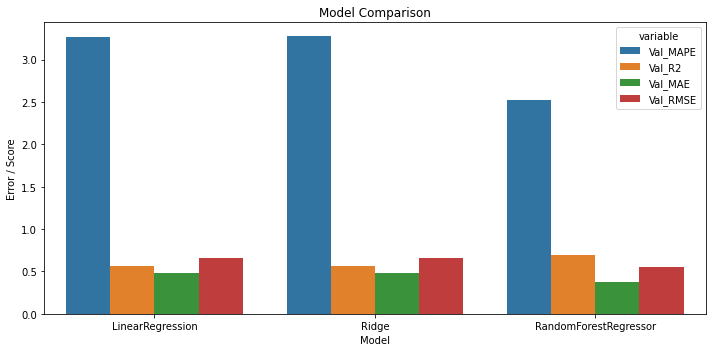

In [24]:
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
melted['Score'] = melted.groupby('Metric')['Score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison")
plt.ylabel("Error / Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

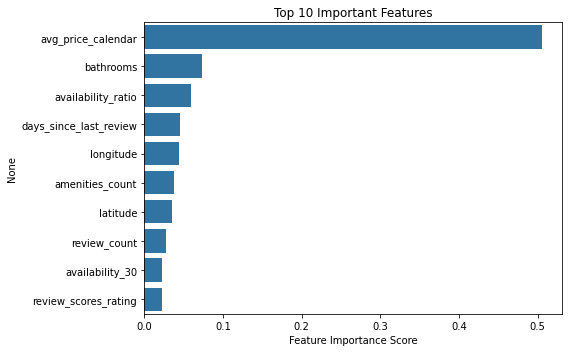

In [27]:
# Choose best model manually or based on R²
best_model = models[2]

importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

In [30]:
# Define models
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor()
]

test_scores = {}

# Test and evaluate
for model in tqdm(models, desc="Testing models", unit="model"):
    name = model.__class__.__name__
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    
    test_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
        'R2': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }

# Convert to DataFrame for comparison
test_scores_df = pd.DataFrame(test_scores).T

print("Training Scores:\n", test_scores_df)

Testing models: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.09s/model]

Training Scores:
                            MAPE        R2       MAE      RMSE
LinearRegression       3.285625  0.599198  0.475681  0.637768
Ridge                  3.287876  0.599179  0.474944  0.637782
RandomForestRegressor  1.813258  0.719918  0.362593  0.533139
